## Garch-based Volatility Prediction

In [59]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.stattools import adfuller
from arch import arch_model
from statsmodels.stats.diagnostic import acorr_ljungbox
import warnings
warnings.filterwarnings("ignore")

In [60]:
# Loading S&P 500 stock data

ticker = 'SPY'
start_date = '2004-01-01'
end_date = '2025-01-01'

stock_data = yf.download(ticker, start=start_date, end=end_date)

if isinstance(stock_data.columns, pd.MultiIndex):  
    stock_data.columns = stock_data.columns.droplevel(1)

[*********************100%***********************]  1 of 1 completed


In [61]:
stock_data.head()

Price,Close,High,Low,Open,Volume
Date,,,,,
2004-01-02,74.904945,75.551432,74.568233,75.248388,38072300
2004-01-05,75.719795,75.773665,75.147381,75.214727,27959800
2004-01-06,75.793877,75.915093,75.423491,75.531242,20472800
2004-01-07,76.049767,76.137310,75.349405,75.686117,30170400
2004-01-08,76.352821,76.373028,75.942032,76.265278,36438400


In [62]:
# Function to perform ADF test

def adf_test(data):
    try:
        result = adfuller(data)
        return {
            "adf_statistic": result[0],
            "p_value": result[1],
            "critical_values": result[4]
        }
    except ValueError as e:
        print(f"ADF test failed: {e}")
        return None

In [63]:
# Function to try different formula for stationarity and select the best

def stationarity_formula(test_data):
    if not isinstance(test_data, pd.Series):
        raise ValueError("Input data must be a Pandas Series.")

    if test_data.isnull().any():
        print("Warning: Input data contains NaN values. Dropping NaNs.")
        test_data = test_data.dropna()
    
    if test_data.empty:
        raise ValueError("Input data is empty after cleaning.")

    transformations = {
        'percent_change': test_data.pct_change().dropna(),
        'log_transform': np.log(test_data.replace(0, np.nan)).dropna(),
        'log_shift': np.log((test_data / test_data.shift(1)).dropna()),
        'first_difference': test_data.diff().dropna(),
        'squared_root': np.sqrt(test_data).dropna(),
        'cubic_root': np.cbrt(test_data).dropna(),
        'ewma': test_data.ewm(span=10).mean().dropna()
    }
    
    results = {}
    transformed_data = {}

    for name, data in transformations.items():
        if data.empty:
            print(f"Skipping {name}: Transformation resulted in an empty Series.")
            continue

        print(f"\nPerforming ADF test for {name}:")
        metrics = adf_test(data)
        if metrics:
            results[name] = metrics
            transformed_data[name] = data
            print(f"ADF Statistic: {metrics['adf_statistic']}")
            print(f"p-value: {metrics['p_value']}")
            print(f"Critical Values: {metrics['critical_values']}")
        else:
            print(f"Skipping {name}: ADF test failed.")

    best_transformation = None
    best_metrics = {"adf_statistic": float("inf"), "p_value": 1.0}

    for name, metrics in results.items():
        if metrics["p_value"] < 0.05 and metrics["adf_statistic"] < best_metrics["adf_statistic"]:
            best_transformation = name
            best_metrics = metrics

    if best_transformation:
        print(f"\nBest transformation: {best_transformation}")
        print(f"ADF Statistic: {best_metrics['adf_statistic']}")
        print(f"p-value: {best_metrics['p_value']}")
        return best_transformation, best_metrics, transformed_data[best_transformation]
    else:
        print("\nNo transformation resulted in stationarity.")
        return None, None, None

Text(0.5, 1.0, 'SPY Stock Prices')

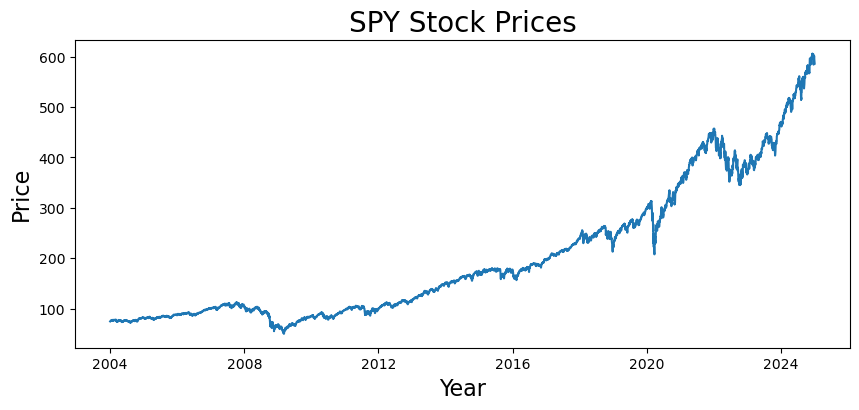

In [64]:
plt.figure(figsize=(10,4))
plt.plot(stock_data['Close'])
plt.ylabel('Price', fontsize=16)
plt.xlabel('Year', fontsize=16)
plt.title(f'{ticker} Stock Prices', fontsize=20)

In [65]:
best_transformation, best_metrics, transformed_data = stationarity_formula(stock_data['Close'])


Performing ADF test for percent_change:
ADF Statistic: -18.244119590070962
p-value: 2.3511765402349827e-30
Critical Values: {'1%': -3.431592402294554, '5%': -2.862089013571916, '10%': -2.5670622395408187}

Performing ADF test for log_transform:
ADF Statistic: 0.5743011090087916
p-value: 0.9869647659254058
Critical Values: {'1%': -3.431592402294554, '5%': -2.862089013571916, '10%': -2.5670622395408187}

Performing ADF test for log_shift:
ADF Statistic: -17.90843891805793
p-value: 2.935639160513325e-30
Critical Values: {'1%': -3.431592402294554, '5%': -2.862089013571916, '10%': -2.5670622395408187}

Performing ADF test for first_difference:
ADF Statistic: -14.585478143239614
p-value: 4.399036217415568e-27
Critical Values: {'1%': -3.4315952412974227, '5%': -2.8620902678554794, '10%': -2.56706290724025}

Performing ADF test for squared_root:
ADF Statistic: 1.6267101563173305
p-value: 0.9979355370060206
Critical Values: {'1%': -3.4315916945653697, '5%': -2.862088700893961, '10%': -2.567062

Text(0.5, 1.0, 'SPY Returns')

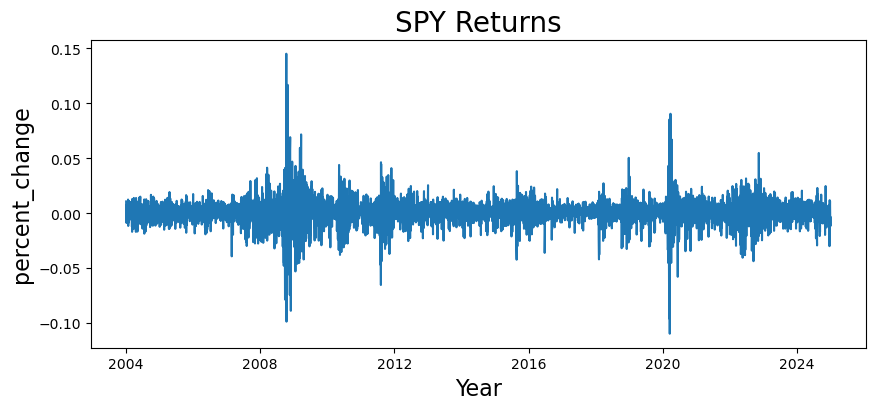

In [66]:
plt.figure(figsize=(10,4))
plt.plot(transformed_data)
plt.ylabel(best_transformation, fontsize=16)
plt.xlabel('Year', fontsize=16)
plt.title(f'{ticker} Returns', fontsize=20)

<Figure size 1200x600 with 0 Axes>

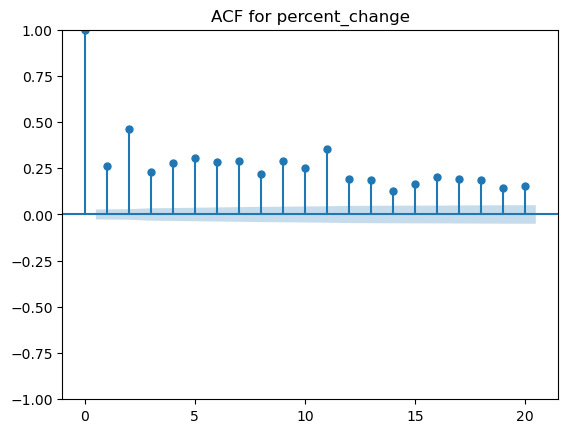

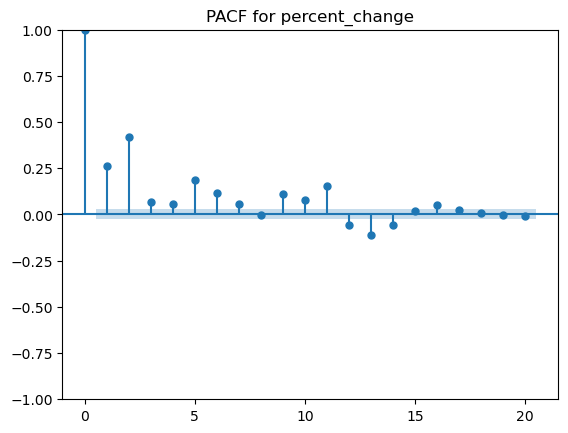

In [67]:
plt.figure(figsize=(12, 6))
plot_acf(transformed_data**2, lags=20, title=f"ACF for {best_transformation}")
plot_pacf(transformed_data**2, lags=20, method="ywmle", title=f"PACF for {best_transformation}")
plt.show()

In [68]:
# Evaluates GARCH, EGARCH, and TGARCH models for different (p, q) combinations and stores the AIC, BIC, and Ljung-Box test p-values in a DataFrame.

def evaluate_garch_models(data, max_p=3, max_q=3, lags=10):
    models = ["GARCH", "EGARCH", "TGARCH"]
    results = []

    for model_type in models:
        for p in range(1, max_p + 1):
            for q in range(1, max_q + 1):
                try:
                    if model_type == "GARCH":
                        model = arch_model(data, vol="GARCH", p=p, q=q)
                    elif model_type == "EGARCH":
                        model = arch_model(data, vol="EGARCH", p=p, q=q)
                    elif model_type == "TGARCH":
                        model = arch_model(data, vol="GARCH", p=p, q=q, power=1.0)

                    fitted_model = model.fit(disp="off")

                    residuals = fitted_model.resid
                    ljung_box_results = acorr_ljungbox(residuals, lags=[lags], return_df=True)
                    lb_pvalue = ljung_box_results["lb_pvalue"].iloc[-1]

                    results.append({
                        "Model": model_type,
                        "p": p,
                        "q": q,
                        "AIC": fitted_model.aic,
                        "BIC": fitted_model.bic,
                        "Ljung-Box p-value": lb_pvalue
                    })
                except Exception as e:
                    results.append({
                        "Model": model_type,
                        "p": p,
                        "q": q,
                        "AIC": None,
                        "BIC": None,
                        "Ljung-Box p-value": None
                    })

    results_df = pd.DataFrame(results)
    return results_df

In [69]:
results_df = evaluate_garch_models(transformed_data, max_p=2, max_q=2, lags=10)

C:\ProgramData\anaconda3\Lib\site-packages\arch\univariate\base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


In [70]:
results_df

,Model,p,q,AIC,BIC,Ljung-Box p-value
0,GARCH,1,1,-34768.976013,-34742.686258,1.921200e-17
1,GARCH,1,2,-34749.174240,-34716.312047,1.921200e-17
2,GARCH,2,1,14796.193416,14829.055610,1.921200e-17
3,GARCH,2,2,-34799.446704,-34760.012072,1.921200e-17
4,EGARCH,1,1,-34758.755513,-34732.465758,1.921200e-17
5,EGARCH,1,2,-34756.755513,-34723.893320,1.921200e-17
6,EGARCH,2,1,-34760.031026,-34727.168833,1.921200e-17
7,EGARCH,2,2,-34768.831977,-34729.397345,1.921200e-17
8,TGARCH,1,1,-34773.262097,-34746.972342,1.921200e-17
9,TGARCH,1,2,-34771.262097,-34738.399904,1.921200e-17


**GARCH(2,2) has the lowest AIC and BIC values. So we will use this model to predict volatility.**

In [71]:
# Forecasting volatility of the next day using a rolling window.

rolling_predictions = []
test_size = 365

for i in range(test_size):
    train = transformed_data[:-(test_size-i)]
    model = arch_model(train, vol="GARCH", p=2, q=2)
    model_fit = model.fit(disp='off')
    pred = model_fit.forecast(horizon=1)
    rolling_predictions.append(np.sqrt(pred.variance.values[-1,:][0]))

C:\ProgramData\anaconda3\Lib\site-packages\arch\univariate\base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


In [72]:
rolling_predictions = pd.Series(rolling_predictions, index=transformed_data.index[-365:])

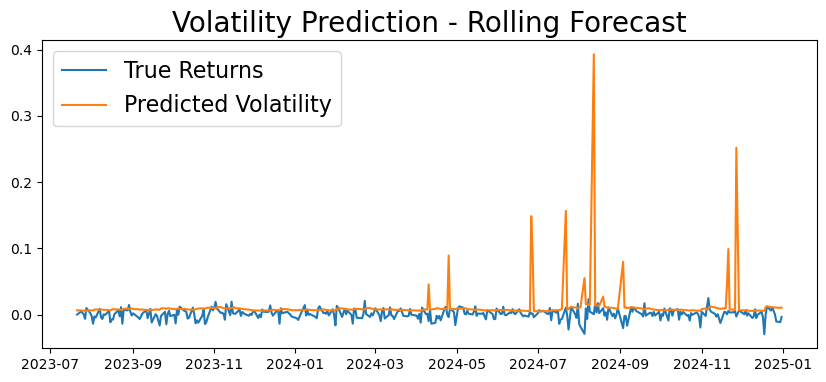

In [73]:
plt.figure(figsize=(10,4))
true, = plt.plot(transformed_data[-365:])
preds, = plt.plot(rolling_predictions)
plt.title('Volatility Prediction - Rolling Forecast', fontsize=20)
plt.legend(['True Returns', 'Predicted Volatility'], fontsize=16)

In [74]:
stock_data['Predicted_Volatility'] = rolling_predictions

In [75]:
# Function to classify volatility into high or low using a threshold.

def classify_volatility(volatility, method):
    if method == "median":
        threshold = volatility.median()
    elif method == "mean":
        threshold = volatility.mean()
    else:
        threshold = float(method)
    
    labels = (volatility > threshold).astype(int)
    return labels

## Algotrading

In [76]:
# Function to compute the MACD (Moving Average Convergence Divergence) indicator.

def compute_macd(data, short_window=12, long_window=26, signal_window=9):
    data["MACD"] = data["Close"].ewm(span=short_window, adjust=False).mean() - \
                   data["Close"].ewm(span=long_window, adjust=False).mean()
    data["Signal"] = data["MACD"].ewm(span=signal_window, adjust=False).mean()
    return data

In [77]:
# Function to determine Renko trend direction.

def compute_renko_trend(data, brick_size=2):
    renko_trend = []
    previous_brick = None

    for price in data["Close"]:
        brick = np.floor(price / brick_size)  # Renko brick number
        if previous_brick is None:
            renko_trend.append(0)
        elif brick > previous_brick:
            renko_trend.append(1)  # Uptrend
        elif brick < previous_brick:
            renko_trend.append(-1)  # Downtrend
        else:
            renko_trend.append(renko_trend[-1])  # Maintain trend

        previous_brick = brick

    data["Renko_Trend"] = renko_trend
    return data

In [78]:
# Function to compute the Relative Strength Index (RSI).

def compute_rsi(data, window=14):
    delta = data["Close"].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    
    rs = gain / loss
    data["RSI"] = 100 - (100 / (1 + rs))
    return data

In [79]:
# Function to compute the On Balance Volume (OBV).

def compute_obv(data):
    data["OBV"] = (data["Volume"] * ((data["Close"].diff() > 0) * 2 - 1)).cumsum()
    return data

In [80]:
# Function to compute MACD, RSI, OBV, ATR, Renko Trend and Resistance Levels.

def compute_technical_indicators(data):
    data = compute_macd(data)
    data = compute_rsi(data)
    data = compute_obv(data)
    data = compute_renko_trend(data)
    return data

In [81]:
data1 = compute_technical_indicators(stock_data)

In [82]:
data1.head()

Price,Close,High,Low,Open,Volume,Predicted_Volatility,MACD,Signal,RSI,OBV,Renko_Trend
Date,,,,,,,,,,,
2004-01-02,74.904945,75.551432,74.568233,75.248388,38072300,NaN,0.000000,0.000000,NaN,-38072300,0
2004-01-05,75.719795,75.773665,75.147381,75.214727,27959800,NaN,0.065002,0.013000,NaN,-10112500,0
2004-01-06,75.793877,75.915093,75.423491,75.531242,20472800,NaN,0.121099,0.034620,NaN,10360300,0
2004-01-07,76.049767,76.137310,75.349405,75.686117,30170400,NaN,0.184082,0.064512,NaN,40530700,1
2004-01-08,76.352821,76.373028,75.942032,76.265278,36438400,NaN,0.255505,0.102711,NaN,76969100,1


In [83]:
trading_df = data1[-365:]

In [84]:
volatility_classification = classify_volatility(rolling_predictions, method="median")
trading_df['Volatility_label'] = volatility_classification

In [85]:
trading_df.head()

Price,Close,High,Low,Open,Volume,Predicted_Volatility,MACD,Signal,RSI,OBV,Renko_Trend,Volatility_label
Date,,,,,,,,,,,,
2023-07-21,443.087463,445.037468,443.077685,444.831670,71245400,0.006289,6.154358,5.827959,67.128428,12482848100,-1,0
2023-07-24,445.066895,445.890000,443.205076,444.253568,54023400,0.006246,6.142299,5.890827,68.934104,12536871500,1,0
2023-07-25,446.281952,447.555799,444.743515,444.792527,55191200,0.005914,6.159782,5.944618,71.927323,12592062700,1,0
2023-07-26,446.350555,447.800776,444.263381,445.331460,71052900,0.005787,6.108755,5.977445,82.123718,12663115600,1,0
2023-07-27,443.391266,450.201526,442.470165,449.789959,92194400,0.005479,5.763092,5.934575,76.222603,12570921200,-1,0


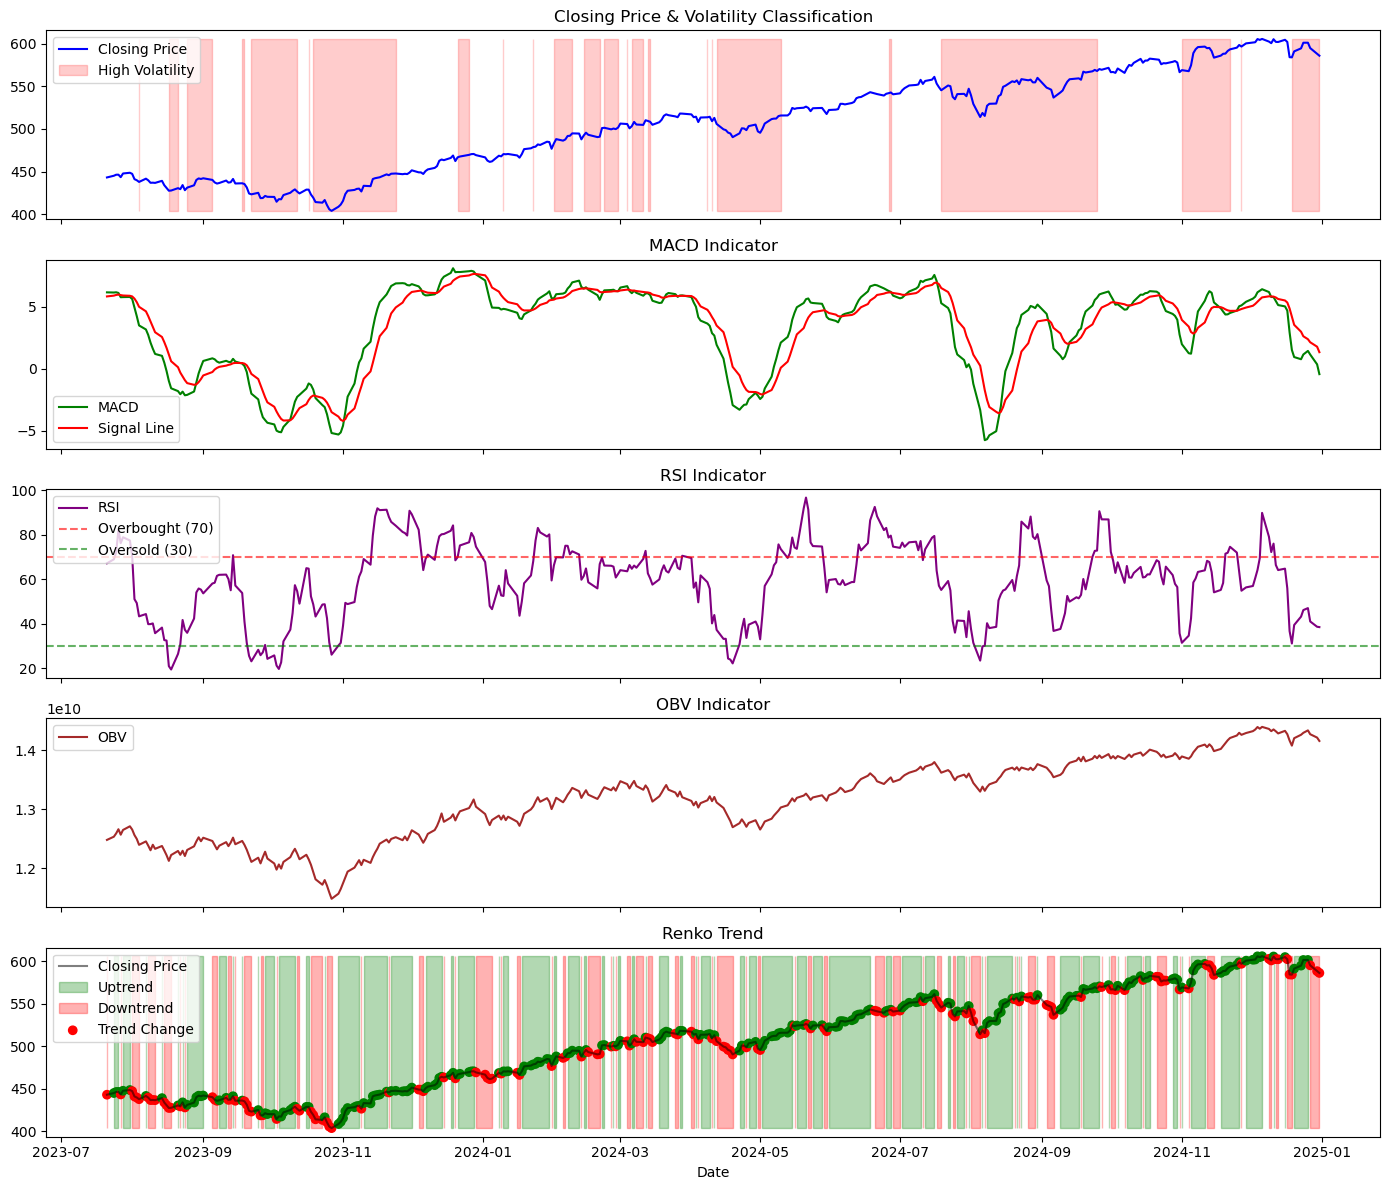

In [86]:
# Visualising all technical indicators

fig, axs = plt.subplots(5, 1, figsize=(14, 12), sharex=True)

axs[0].plot(trading_df.index, trading_df["Close"], label="Closing Price", color="blue")
axs[0].fill_between(trading_df.index, trading_df["Close"].min(), trading_df["Close"].max(),
                    where=(trading_df["Volatility_label"] == 1), color="red", alpha=0.2, label="High Volatility")
axs[0].set_title("Closing Price & Volatility Classification")
axs[0].legend()

axs[1].plot(trading_df.index, trading_df["MACD"], label="MACD", color="green")
axs[1].plot(trading_df.index, trading_df["Signal"], label="Signal Line", color="red")
axs[1].set_title("MACD Indicator")
axs[1].legend()

axs[2].plot(trading_df.index, trading_df["RSI"], label="RSI", color="purple")
axs[2].axhline(70, linestyle="--", color="red", alpha=0.6, label="Overbought (70)")
axs[2].axhline(30, linestyle="--", color="green", alpha=0.6, label="Oversold (30)")
axs[2].set_title("RSI Indicator")
axs[2].legend()

axs[3].plot(trading_df.index, trading_df["OBV"], label="OBV", color="brown")
axs[3].set_title("OBV Indicator")
axs[3].legend()

axs[4].plot(trading_df.index, trading_df["Close"], label="Closing Price", color="black", alpha=0.5)
axs[4].fill_between(trading_df.index, trading_df["Close"].min(), trading_df["Close"].max(),
                    where=(trading_df["Renko_Trend"] == 1), color="green", alpha=0.3, label="Uptrend")
axs[4].fill_between(trading_df.index, trading_df["Close"].min(), trading_df["Close"].max(),
                    where=(trading_df["Renko_Trend"] == -1), color="red", alpha=0.3, label="Downtrend")
axs[4].scatter(trading_df.index, trading_df["Close"], c=trading_df["Renko_Trend"].map({1: "green", -1: "red"}), label="Trend Change", marker="o")
axs[4].set_title("Renko Trend")
axs[4].legend()

plt.xlabel("Date")
plt.tight_layout()
plt.show()

In [87]:
# Function to apply a trading strategy and store trading signals as 0 (Sell) or 1 (Buy).

def apply_trading_strategy(data, strategy_name):
    buy_signals = []
    sell_signals = []

    data[f"{strategy_name}_Signal"] = 0

    for i in range(5, len(data)):
        buy = False
        sell = False

        if strategy_name == "MACD_Renko":
            macd_up = (data["MACD"].iloc[i] > data["Signal"].iloc[i]) and \
                      (data["MACD"].diff(5).iloc[i] > data["Signal"].diff(5).iloc[i])
            macd_down = (data["MACD"].iloc[i] < data["Signal"].iloc[i])

            renko_up = data["Renko_Trend"].iloc[i] == 1
            renko_down = data["Renko_Trend"].iloc[i] == -1

            if macd_up and renko_up:
                buy = True
            if macd_down and renko_down:
                sell = True

        elif strategy_name == "MACD_RSI":
            rsi_up = data["RSI"].iloc[i] > 30 and data["RSI"].diff().iloc[i] > 0
            rsi_down = data["RSI"].iloc[i] < 70 and data["RSI"].diff().iloc[i] < 0

            macd_up = data["MACD"].iloc[i] > data["Signal"].iloc[i]
            macd_down = data["MACD"].iloc[i] < data["Signal"].iloc[i]

            if macd_up and rsi_up:
                buy = True
            if macd_down and rsi_down:
                sell = True

        elif strategy_name == "OBV_Renko":
            obv_up = data["OBV"].iloc[i] > data["OBV"].iloc[i - 5]
            obv_down = data["OBV"].iloc[i] < data["OBV"].iloc[i - 5]

            renko_up = data["Renko_Trend"].iloc[i] == 1
            renko_down = data["Renko_Trend"].iloc[i] == -1

            if obv_up and renko_up:
                buy = True
            if obv_down and renko_down:
                sell = True

        elif strategy_name == "MACD_OBV":
            macd_up = data["MACD"].iloc[i] > data["Signal"].iloc[i]
            macd_down = data["MACD"].iloc[i] < data["Signal"].iloc[i]

            obv_up = data["OBV"].iloc[i] > data["OBV"].iloc[i - 5]
            obv_down = data["OBV"].iloc[i] < data["OBV"].iloc[i - 5]

            if macd_up and obv_up:
                buy = True
            if macd_down and obv_down:
                sell = True

        if data["Volatility_label"].iloc[i] == 1:
            if buy:
                buy_signals.append(data.index[i])
                data.at[data.index[i], f"{strategy_name}_Signal"] = 1
            if sell:
                sell_signals.append(data.index[i])
                data.at[data.index[i], f"{strategy_name}_Signal"] = 0

    return data, buy_signals, sell_signals

In [88]:
# Function to plot generated buy & sell signals for a given strategy.

def plot_generated_trading_signals(data, strategy_name, buy_signals, sell_signals):
    plt.figure(figsize=(14, 6))
    
    plt.plot(data.index, data["Close"], label="Closing Price", color="blue", alpha=0.6)
    
    plt.scatter(buy_signals, data.loc[buy_signals, "Close"], marker="^", color="green", label="Generated Buy", alpha=1)
    plt.scatter(sell_signals, data.loc[sell_signals, "Close"], marker="v", color="red", label="Generated Sell", alpha=1)

    plt.fill_between(data.index, data["Close"].min(), data["Close"].max(), where=(data["Volatility_label"] == 1), color="red", alpha=0.2)

    plt.title(f"{strategy_name} - Generated Trading Signals")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.legend()
    plt.show()

In [89]:
# Function to plot actual executed buy & sell trades for a given strategy.

def plot_executed_trades(data, strategy_name, executed_trades):
    plt.figure(figsize=(14, 6))
    
    plt.plot(data.index, data["Close"], label="Closing Price", color="blue", alpha=0.6)
    
    plt.scatter(executed_trades["Buy"], data.loc[executed_trades["Buy"], "Close"], marker="o", color="darkgreen", label="Executed Buy", alpha=1)
    plt.scatter(executed_trades["Sell"], data.loc[executed_trades["Sell"], "Close"], marker="x", color="darkred", label="Executed Sell", alpha=1)

    plt.title(f"{strategy_name} - Actual Executed Trades")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.legend()
    plt.show()

In [90]:
# Function to build a portfolio and track executed trades, win ratio, and portfolio return.

def build_portfolio(data, buy_signals, sell_signals, initial_cash=10000):
    cash = initial_cash
    shares = 0
    portfolio_value = []
    cash_balance = []
    holdings_value = []
    executed_trades = {"Buy": [], "Sell": []}
    
    trade_wins = 0
    executed_trade_count = 0
    last_buy_price = None

    for i in range(len(data)):
        price = data["Close"].iloc[i]

        if data.index[i] in buy_signals:
            shares_to_buy = cash // price
            cost = shares_to_buy * price
            if shares_to_buy > 0:
                cash -= cost
                shares += shares_to_buy
                executed_trades["Buy"].append(data.index[i])
                last_buy_price = price
                executed_trade_count += 1

        elif data.index[i] in sell_signals and shares > 0:
            if last_buy_price is not None and price > last_buy_price:
                trade_wins += 1

            cash += shares * price
            shares = 0
            executed_trades["Sell"].append(data.index[i])
            executed_trade_count += 1 

        total_value = cash + (shares * price)
        portfolio_value.append(total_value)
        cash_balance.append(cash)
        holdings_value.append(shares * price)

    data["Portfolio_Value"] = portfolio_value
    data["Cash_Balance"] = cash_balance
    data["Holdings_Value"] = holdings_value

    win_ratio = (trade_wins / executed_trade_count) * 100 if executed_trade_count > 0 else 0

    portfolio_return = ((portfolio_value[-1] - initial_cash) / initial_cash) * 100

    return data, executed_trades, win_ratio, portfolio_return, executed_trade_count

In [91]:
# Function to compute Sharpe Ratio, Maximum Drawdown, and Final Portfolio Value.

def compute_performance_metrics(portfolio):
    returns = portfolio["Portfolio_Value"].pct_change().dropna()
    sharpe_ratio = returns.mean() / returns.std() * np.sqrt(252) if returns.std() != 0 else 0

    running_max = portfolio["Portfolio_Value"].cummax()
    drawdowns = portfolio["Portfolio_Value"] / running_max - 1
    max_drawdown = drawdowns.min()
    
    final_portfolio_value = portfolio["Portfolio_Value"].iloc[-1]
    
    return sharpe_ratio, max_drawdown, final_portfolio_value

<Figure size 1400x700 with 0 Axes>

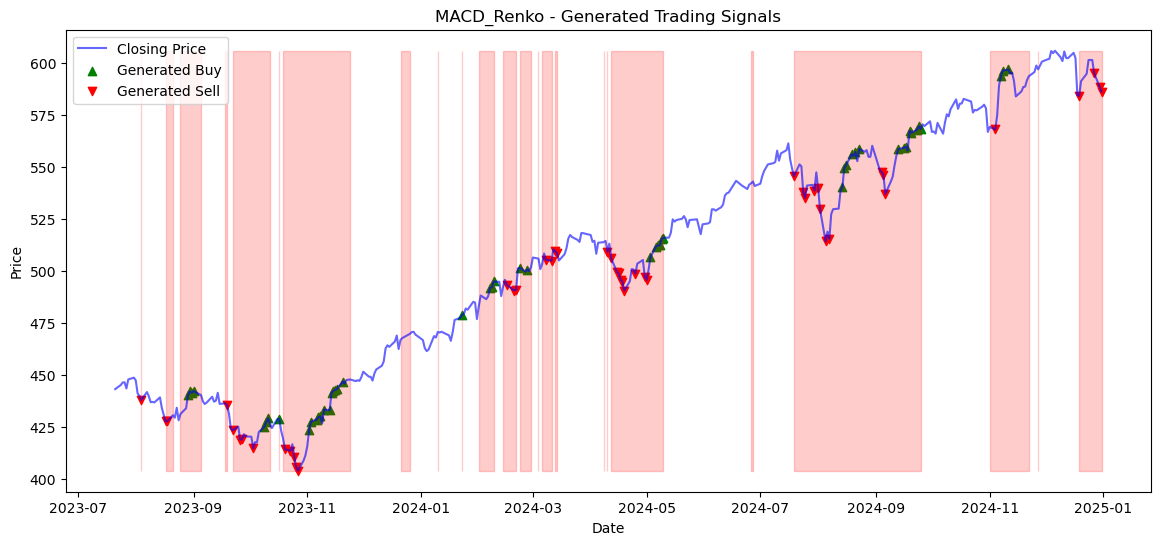

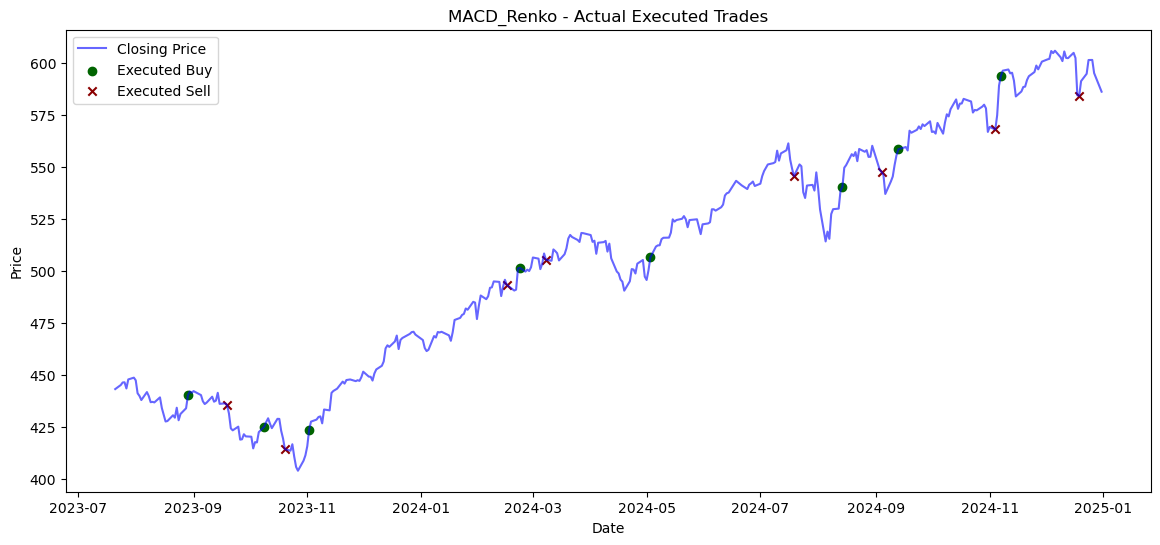

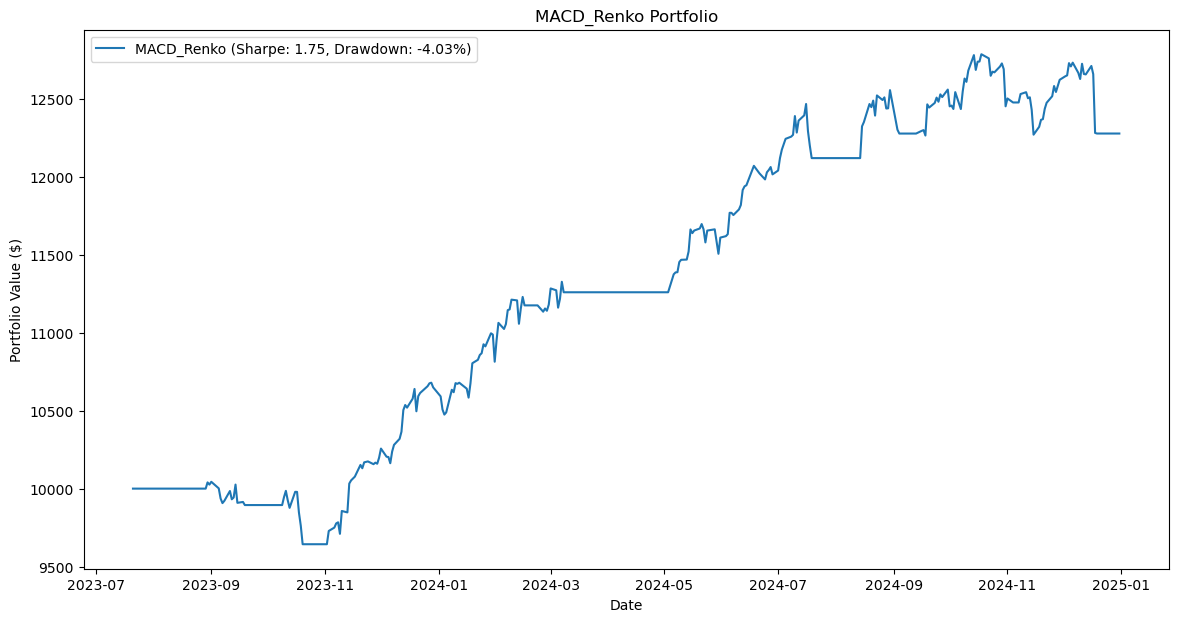

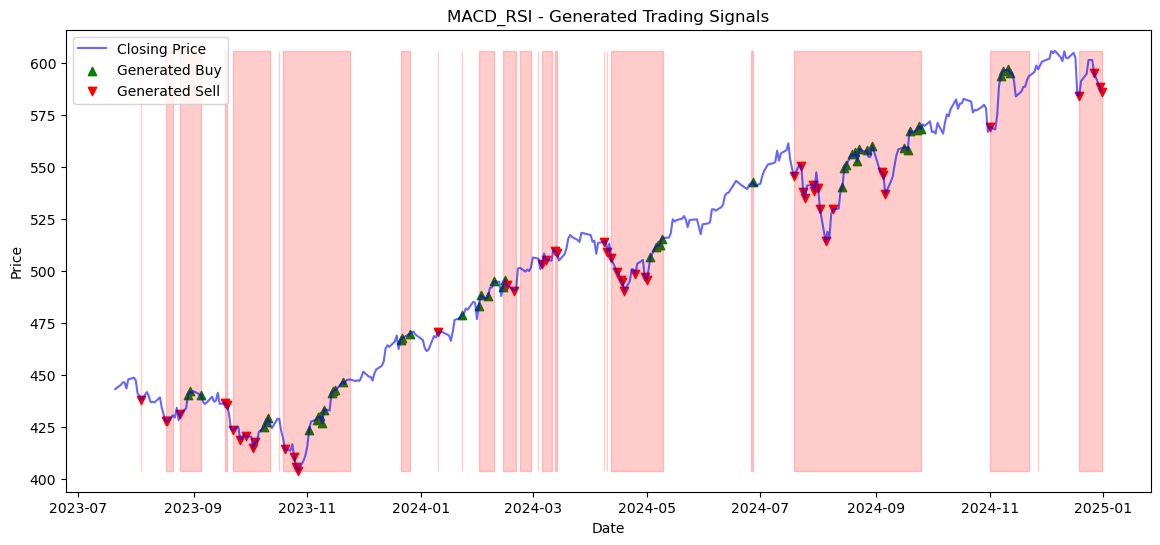

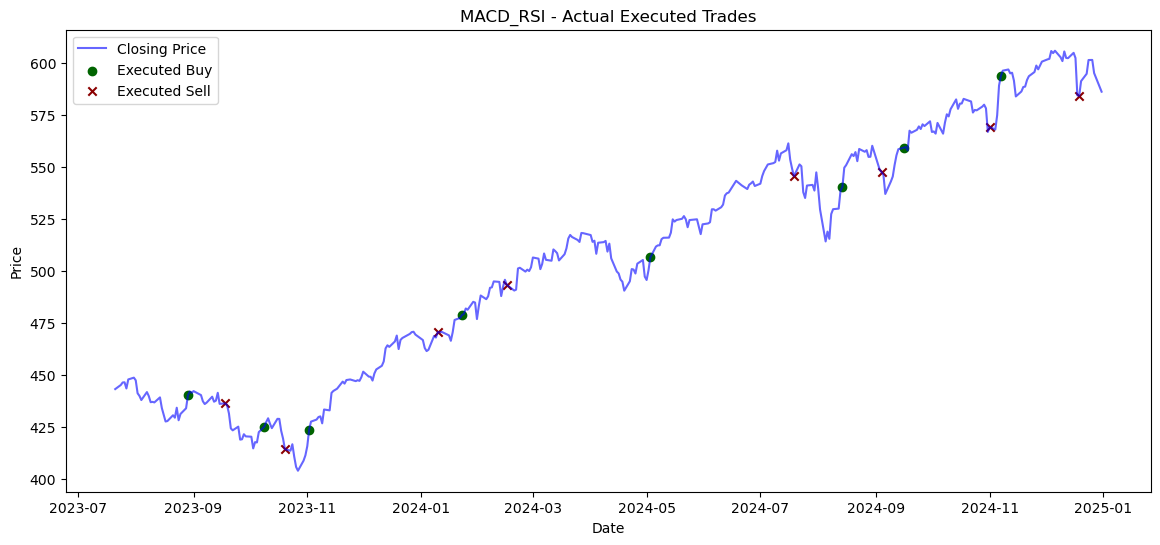

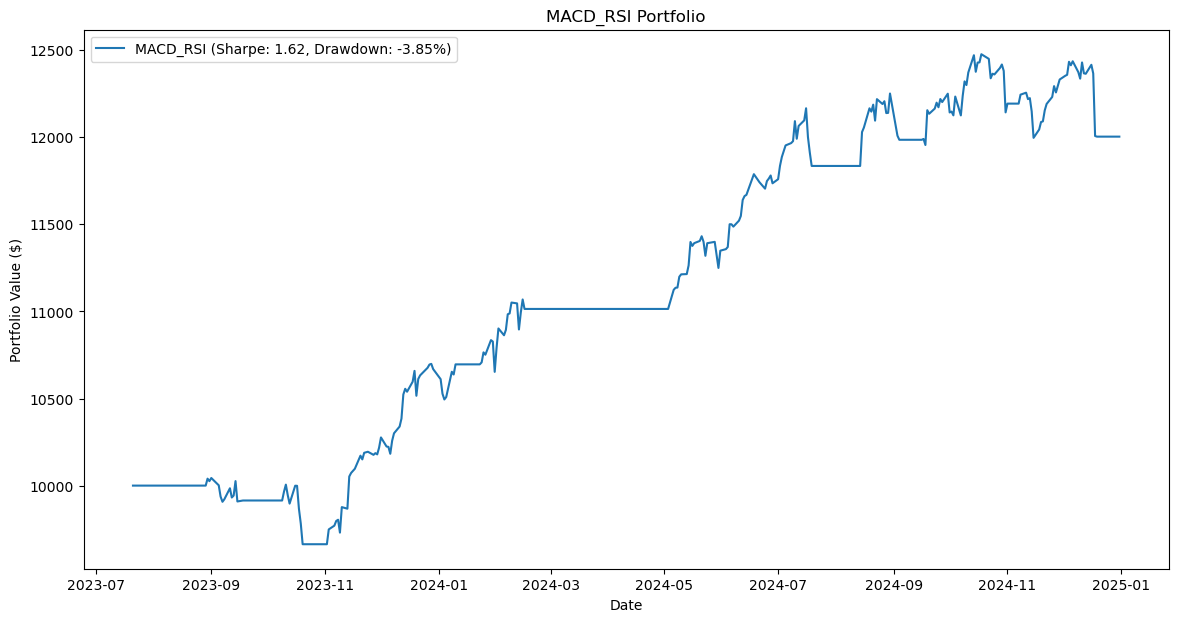

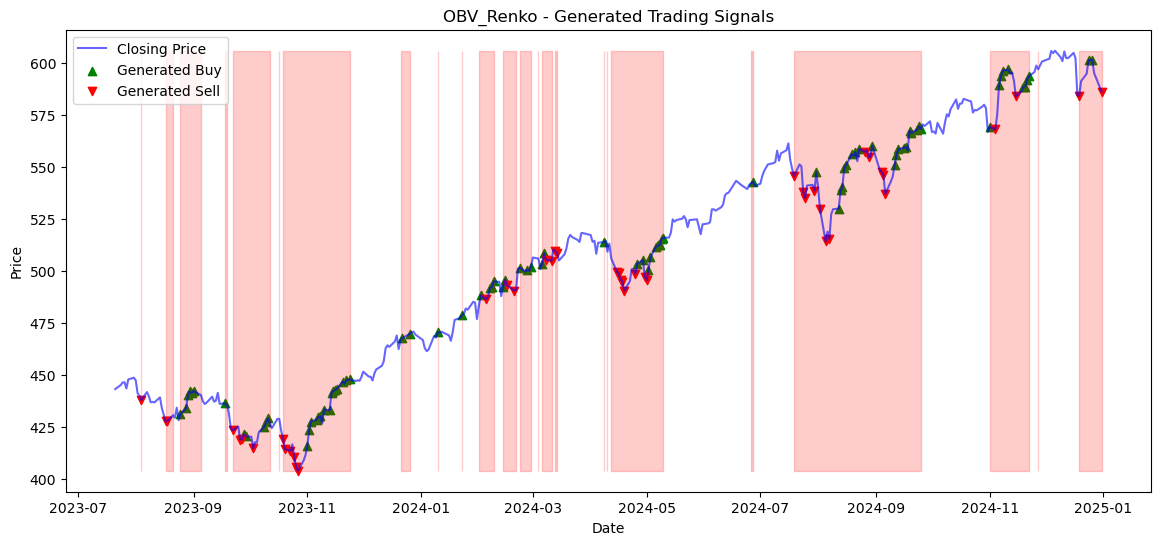

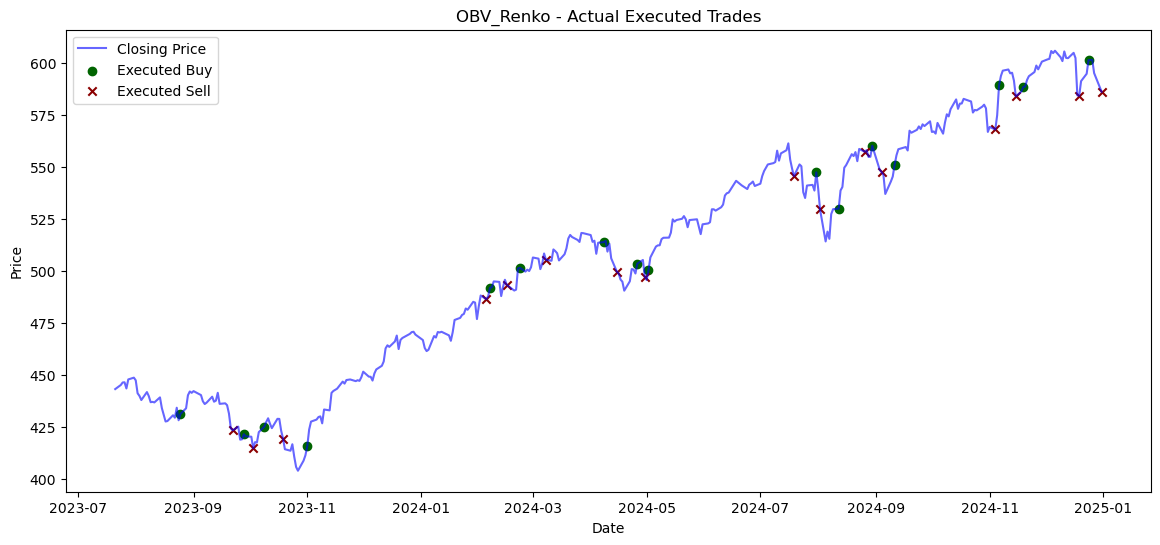

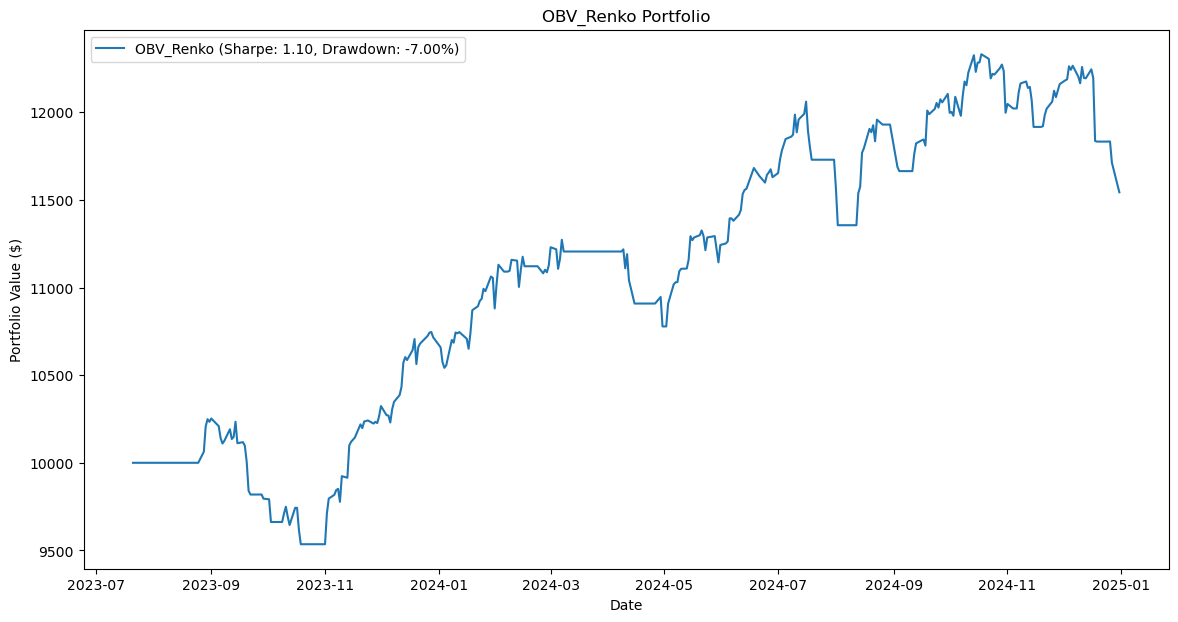

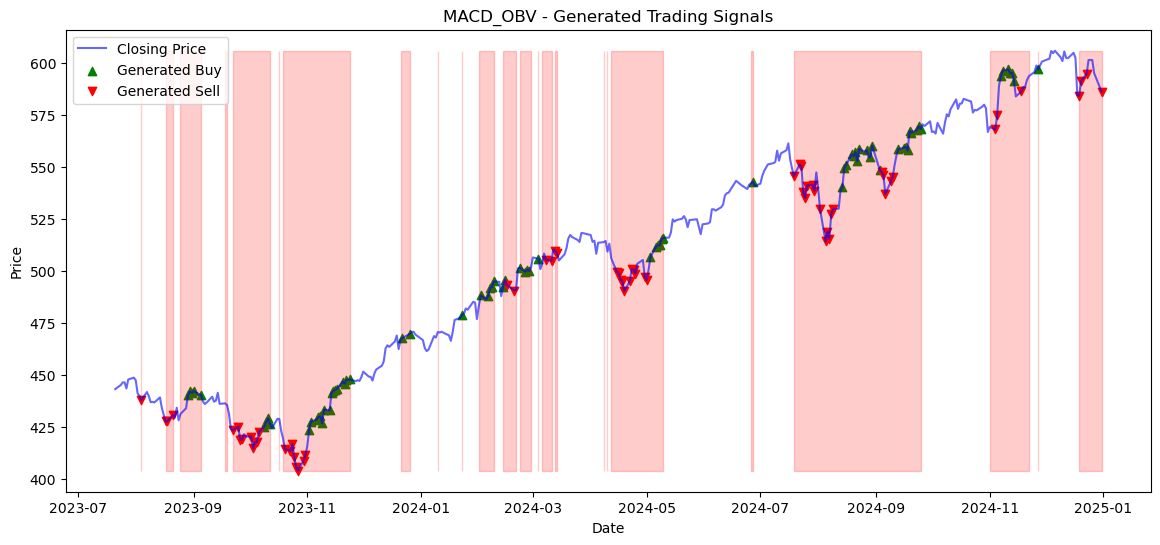

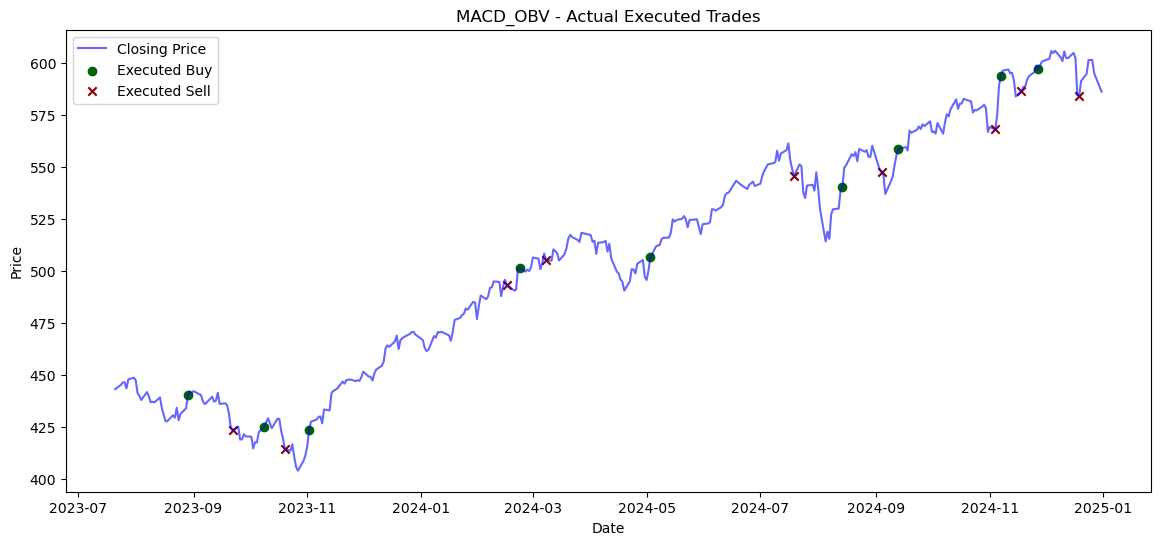

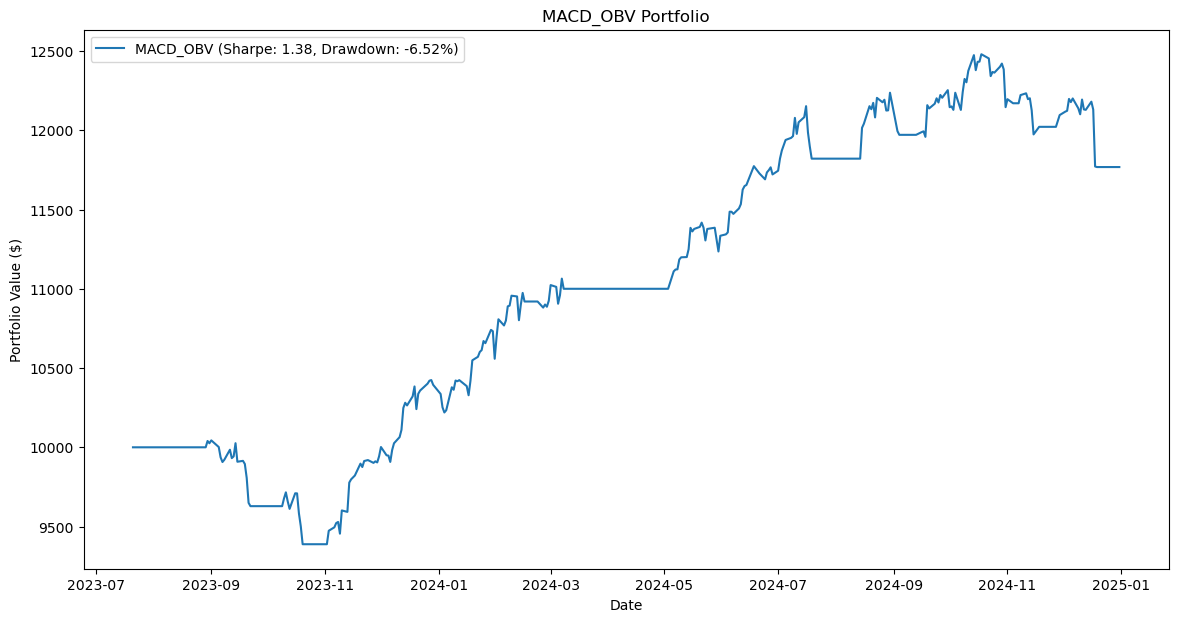

In [98]:
# Visualising the computed technical indicators.

strategies = ["MACD_Renko", "MACD_RSI", "OBV_Renko", "MACD_OBV"]

portfolio_results = []

plt.figure(figsize=(14, 7))

for strategy in strategies:
    strategy_data, buy_signals, sell_signals = apply_trading_strategy(trading_df.copy(), strategy)

    portfolio, executed_trades, win_ratio, portfolio_return, executed_trade_count = build_portfolio(
        strategy_data, buy_signals, sell_signals
    )

    globals()[f"{strategy}_portfolio"] = portfolio
    
    sharpe_ratio, max_drawdown, final_value = compute_performance_metrics(portfolio)

    portfolio_results.append({
        "Strategy": strategy,
        "Sharpe Ratio": sharpe_ratio,
        "Max Drawdown (%)": max_drawdown * 100,
        "Portfolio Return (%)": portfolio_return,
        "Win Ratio (%)": win_ratio,
        "Executed Trades": executed_trade_count,
        "Final Portfolio Value ($)": final_value
    })
    
    plot_generated_trading_signals(strategy_data, strategy, buy_signals, sell_signals)
    plot_executed_trades(strategy_data, strategy, executed_trades)

    plt.figure(figsize=(14, 7))
    plt.plot(portfolio.index, portfolio["Portfolio_Value"], label=f"{strategy} (Sharpe: {sharpe_ratio:.2f}, Drawdown: {max_drawdown:.2%})")
    plt.xlabel("Date")
    plt.ylabel("Portfolio Value ($)")
    plt.title(f"{strategy} Portfolio")
    plt.legend()
    plt.show()

In [99]:
performance_df = pd.DataFrame(portfolio_results)

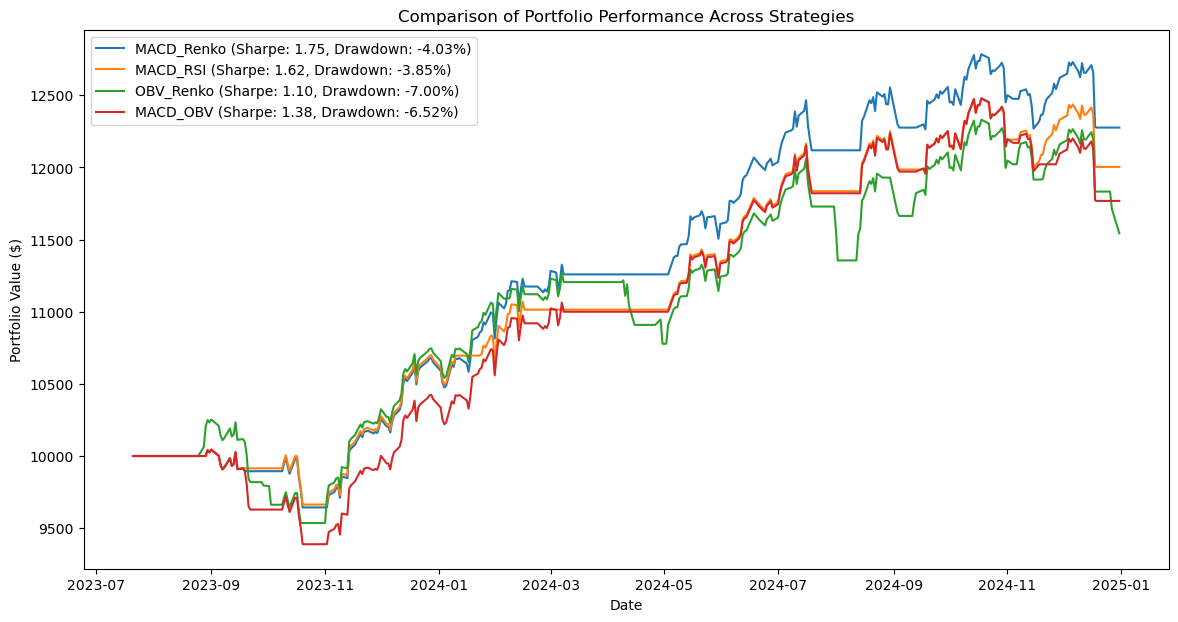

In [100]:
# Plotting all strategies together in one chart.

plt.figure(figsize=(14, 7))
for strategy in strategies:
    portfolio = globals()[f"{strategy}_portfolio"]
    sharpe_ratio, max_drawdown, final_value = compute_performance_metrics(portfolio)
    
    plt.plot(portfolio.index, portfolio["Portfolio_Value"], label=f"{strategy} (Sharpe: {sharpe_ratio:.2f}, Drawdown: {max_drawdown:.2%})")

plt.xlabel("Date")
plt.ylabel("Portfolio Value ($)")
plt.title("Comparison of Portfolio Performance Across Strategies")
plt.legend()
plt.show()

In [101]:
performance_df

,Strategy,Sharpe Ratio,Max Drawdown (%),Portfolio Return (%),Win Ratio (%),Executed Trades,Final Portfolio Value ($)
0,MACD_Renko,1.750115,-4.033755,22.763532,31.250000,16,12276.353210
1,MACD_RSI,1.620949,-3.848240,20.035641,31.250000,16,12003.564056
2,OBV_Renko,1.101194,-6.997001,15.432217,18.750000,32,11543.221741
3,MACD_OBV,1.376042,-6.523000,17.679194,27.777778,18,11767.919403


**MACD_Renko strategy has the best performance metrics. So we will use this strategy to simulate future prices.**

## Monte Carlo Simulations

In [102]:
trading_df.head()

Price,Close,High,Low,Open,Volume,Predicted_Volatility,MACD,Signal,RSI,OBV,Renko_Trend,Volatility_label
Date,,,,,,,,,,,,
2023-07-21,443.087463,445.037468,443.077685,444.831670,71245400,0.006289,6.154358,5.827959,67.128428,12482848100,-1,0
2023-07-24,445.066895,445.890000,443.205076,444.253568,54023400,0.006246,6.142299,5.890827,68.934104,12536871500,1,0
2023-07-25,446.281952,447.555799,444.743515,444.792527,55191200,0.005914,6.159782,5.944618,71.927323,12592062700,1,0
2023-07-26,446.350555,447.800776,444.263381,445.331460,71052900,0.005787,6.108755,5.977445,82.123718,12663115600,1,0
2023-07-27,443.391266,450.201526,442.470165,449.789959,92194400,0.005479,5.763092,5.934575,76.222603,12570921200,-1,0


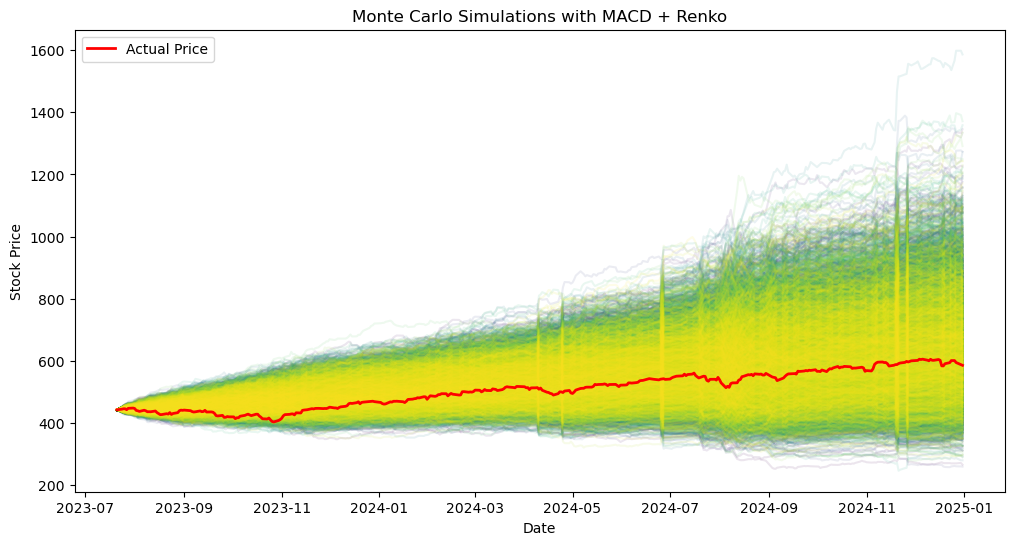

Expected Portfolio Value: $12723.25
Expected Return: 27.23%
Average Win Ratio: 34.13%
Value at Risk (VaR 95%): $9618.66
Conditional Value at Risk (CVaR 95%): $9003.12


In [103]:
# Monte Carlo Simulations to simulate various price paths using the predicted volatility and MACD_Renko trading strategy.

n_simulations = 10000
T = len(trading_df)
S0 = trading_df["Close"].iloc[0]

final_portfolio_values = np.zeros(n_simulations)
final_portfolio_returns = np.zeros(n_simulations)
win_ratios = np.zeros(n_simulations)
executed_trade_counts = np.zeros(n_simulations)

colors = cm.viridis(np.linspace(0, 1, n_simulations))

plt.figure(figsize=(12, 6))

for sim in range(n_simulations):
    simulated_prices = np.zeros(T)
    simulated_prices[0] = S0
    
    cash = 10000
    shares = 0  
    trade_wins = 0
    executed_trade_count = 0
    last_buy_price = None

    for t in range(1, T):
        macd_up = trading_df["MACD"].iloc[t] > trading_df["Signal"].iloc[t]
        macd_down = trading_df["MACD"].iloc[t] < trading_df["Signal"].iloc[t]
        renko_uptrend = trading_df["Renko_Trend"].iloc[t] == 1
        renko_downtrend = trading_df["Renko_Trend"].iloc[t] == -1

        buy_signal = macd_up and renko_uptrend
        sell_signal = macd_down and renko_downtrend

        historical_mu = trading_df["Close"].pct_change().mean()  
        mu_t = historical_mu

        if buy_signal:
            mu_t += 0.0007
            shares_to_buy = cash // simulated_prices[t - 1]
            if shares_to_buy > 0:
                cash -= shares_to_buy * simulated_prices[t - 1]
                shares += shares_to_buy
                last_buy_price = simulated_prices[t - 1]
                executed_trade_count += 1

        elif sell_signal and shares > 0:
            mu_t -= 0.0007
            if last_buy_price is not None and simulated_prices[t - 1] > last_buy_price:
                trade_wins += 1

            cash += shares * simulated_prices[t - 1]
            shares = 0
            executed_trade_count += 1

        sigma_t = min(trading_df["Predicted_Volatility"].iloc[t], 0.05)
        epsilon = np.random.normal(0, 1)
        S_t = simulated_prices[t - 1] * np.exp((mu_t - 0.5 * sigma_t**2) + sigma_t * epsilon)
        simulated_prices[t] = S_t

    total_portfolio_value = cash + (shares * simulated_prices[-1])
    final_portfolio_values[sim] = total_portfolio_value
    final_portfolio_returns[sim] = ((total_portfolio_value - 10000) / 10000) * 100  
    win_ratios[sim] = (trade_wins / executed_trade_count) * 100 if executed_trade_count > 0 else 0
    executed_trade_counts[sim] = executed_trade_count

    plt.plot(trading_df.index, simulated_prices, alpha=0.1, color=colors[sim])

plt.plot(trading_df.index, trading_df["Close"], color="red", linewidth=2, label="Actual Price")
plt.title("Monte Carlo Simulations with MACD + Renko")
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.legend()
plt.show()

expected_portfolio_value = np.mean(final_portfolio_values)
expected_return = np.mean(final_portfolio_returns)
win_ratio_avg = np.mean(win_ratios)
var_95 = np.percentile(final_portfolio_values, 5)  
cvar_95 = np.mean(final_portfolio_values[final_portfolio_values <= var_95])  

print(f"Expected Portfolio Value: ${expected_portfolio_value:.2f}")
print(f"Expected Return: {expected_return:.2f}%")
print(f"Average Win Ratio: {win_ratio_avg:.2f}%")
print(f"Value at Risk (VaR 95%): ${var_95:.2f}")
print(f"Conditional Value at Risk (CVaR 95%): ${cvar_95:.2f}")